<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
       </td>
       <td style="border:none">
           <h1>Interval Jump</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>05. Jump damage</h2></div>

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams["lines.linewidth"] = 2.5

In [3]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [4]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [5]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [164]:
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], ȳ, ξa, ξw )
ϕ_low, ems_low, _, _ = solve_smooth_100(y_grid, args_low, max_iter=5000, tol=1e-7, ϵ=0.5,)

res_list = []
for y_tilde in jump_interval:
    ϕ_list = []
    e_list = []
    for γ3_i in γ3_list[1:]:
        args = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        ϕ, ems, _, _ = solve_smooth_100(y_grid, args, max_iter=5000, tol=1e-7, ϵ=0.5,)
        ϕ_list.append(ϕ)
        e_list.append(ems)
    ϕ_list = np.array(ϕ_list)
    e_list = np.array(e_list)
    res_list.append((ϕ_list, e_list))

episode: 5000,	 ode error: 3.79047342763672e-05,	 ft error: 4.192191606833262e-05
episode: 2563,	 ode error: 0.0003050026779893439,	 ft error: 9.963268965407224e-08
episode: 2783,	 ode error: 0.00126987981738201,	 ft error: 9.980173132362324e-08
episode: 2562,	 ode error: 0.000305649760731469,	 ft error: 9.997995320532027e-08
episode: 2782,	 ode error: 0.0012830526698208045,	 ft error: 9.996664473987948e-08
episode: 2562,	 ode error: 0.00030629526094876763,	 ft error: 9.98617419867287e-08
episode: 2782,	 ode error: 0.0012979659351721662,	 ft error: 9.966808178774045e-08
episode: 2562,	 ode error: 0.00030694026075523545,	 ft error: 9.973930392703778e-08
episode: 2782,	 ode error: 0.0013148999865644061,	 ft error: 9.952389845580001e-08
episode: 2562,	 ode error: 0.00030758606903933533,	 ft error: 9.962861469148265e-08
episode: 2784,	 ode error: 0.0013342024223619532,	 ft error: 9.983494209109267e-08
episode: 2561,	 ode error: 0.00030823350471859134,	 ft error: 9.999516770164973e-08
episo

In [165]:
# construct \phi_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)
ϕ_ref = np.zeros((3, len(pre_jump)))
ems_ref = np.zeros((3, len(pre_jump)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = ϕ_low[i+len(prepre_jump)]
    ϕ_ref[1:, i + len(prepre_jump)] = res_list[i][0][:, i + len(prepre_jump)]
    ems_ref[0, i + len(prepre_jump)] = ems_low[i + len(prepre_jump)]
    ems_ref[1:, i + len(prepre_jump)] = res_list[i][1][:, i + len(prepre_jump)]

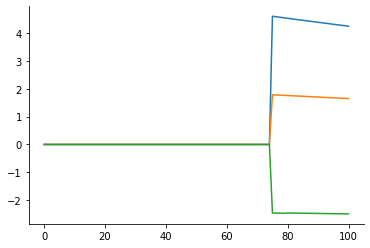

In [166]:
for i in range(3):
    plt.plot(ϕ_ref[i])

In [167]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

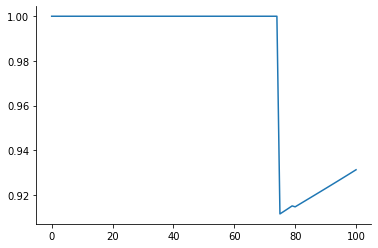

In [168]:
plt.plot(weighted)

In [169]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
r0 = 1/(float(ans[-1])**4 - 1)

In [170]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [171]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2
ϕ_list = np.array([ϕ_low, res_list[-1][0][0], res_list[-1][0][1]])

ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-7
ϵ = 0.25
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
#     g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    - ξp*intensity*(weighted - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems
print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems)

episode: 1583,	 ode error: 0.0026580675681877365,	 ft error: 9.959968494399618e-08


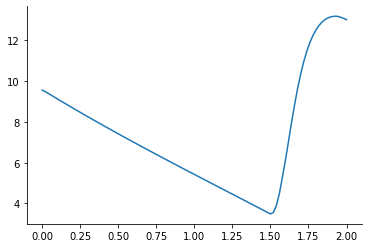

In [172]:
plt.plot(y_grid_cap,ems)

In [173]:
y = 1.1
e = []
for i in range(100):
    e_i = np.interp(y, y_grid_cap, ems)
    e.append(e_i)
    y = y + e_i*np.mean(θ_list)

2.4028185645394062

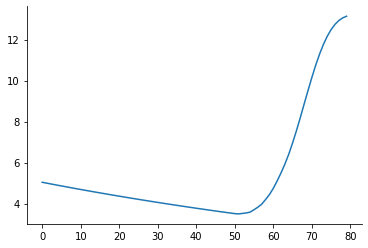

In [174]:
plt.plot(e[:80]); y

In [180]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=80, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            y = y + e_i*θ
        elif y >= y_lower and y <= y_bar:
#             print(t)
            if jumped == False:
                intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
                jump = np.random.binomial(1, intensity_i)
                if jump == 1:
                    jumped = True
                    dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                    dmg_loc,  = np.where(dmg_realization==1)
                    ems_grid_realize = ems_ref[dmg_loc[0]]
                    e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            elif jumped == True:
                e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            y = y + et[t]*θ
    return yt, et

In [181]:
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, N=10_000):
    Yt = list()
    Et = list()
    for s in range(N):
        np.random.seed(N)
        yt, et = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ)
        Yt.append(yt)
        Et.append(et)
    return Yt, Et

In [182]:
Yt, Et = simulate_path(y_grid_cap, ems, ems_ref, np.mean(θ_list))

In [183]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

Text(0.5, 1.0, 'Emission')

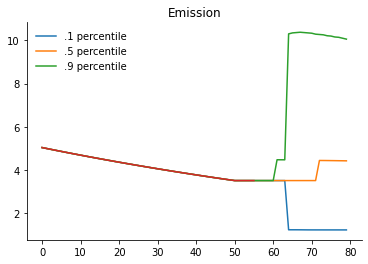

In [184]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:56])
plt.legend(frameon=False)
plt.title('Emission')

In [144]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = (1-η)/((α - invkap)*np.exp(Kt))
    SCCt = MEt/MCt*1000
    return SCCt